In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

%matplotlib inline

In [2]:
from skimage import io
from skimage.feature import canny
from skimage.transform import hough_line, resize

C:\Program Files\Python\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
C:\Program Files\Python\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


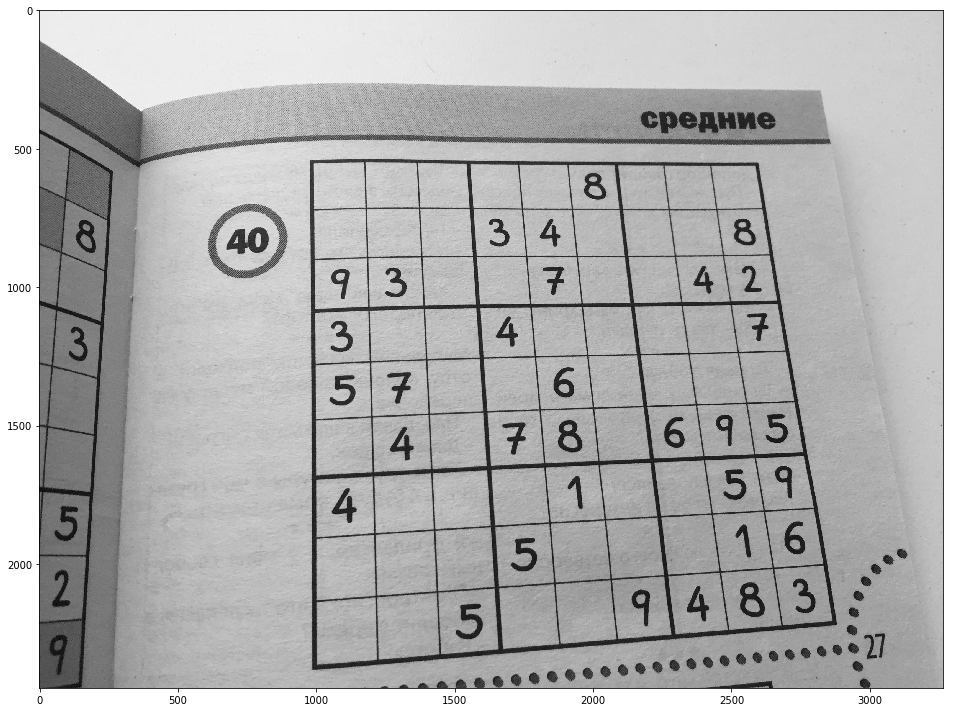

In [3]:
fname = './IMG_1263.jpg'
if fname == './IMG_1263.jpg': #example of the digits from the first photo (1263)
    k = 0
elif fname == './IMG_1286.jpg':
    k = 2
else:
    k = 1
    
    
image_full = io.imread(fname, plugin='matplotlib', as_grey=True)

plt.figure(figsize = (16,10))
io.imshow(image_full)

C:\Program Files\Python\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Program Files\Python\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
C:\Program Files\Python\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


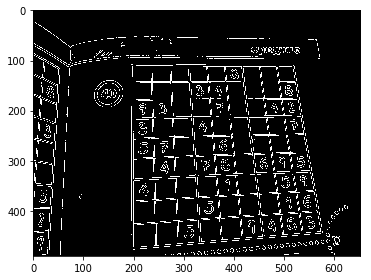

In [4]:
from skimage.transform import rescale
image_scaled = rescale(image_full, 0.2)
if fname == './IMG_1273.jpg' or fname == './IMG_1275.jpg' or fname == './IMG_1276.jpg' or fname == './IMG_1266.jpg':
    image_scaled = rescale(image_full, 0.3)

edges = canny(image_scaled)
io.imshow(edges)

C:\Program Files\Python\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
C:\Program Files\Python\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


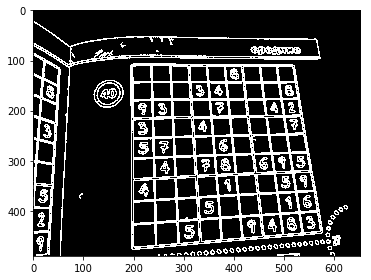

In [5]:
from skimage.morphology import dilation, disk

selem = disk(1)
edges = dilation(edges, selem)
io.imshow(edges)

In [6]:
import cv2

# we need to convert image to uint to apply findContours
edges = (edges).astype(np.uint8)

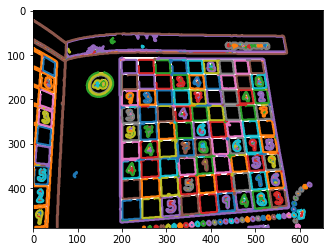

In [7]:
ext_contours = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]

fig, ax = plt.subplots()
ax.imshow(edges, cmap=plt.cm.gray)

for n, contour in enumerate(ext_contours):
    contour = np.array(contour).squeeze()
    if contour.ndim > 1:
        ax.plot(contour[:, 0], contour[:, 1], linewidth=2)

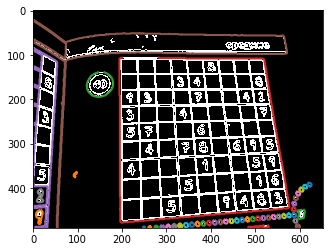

In [8]:
ext_contours = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

fig, ax = plt.subplots()
ax.imshow(edges, cmap=plt.cm.gray)

for n, contour in enumerate(ext_contours):
    contour = np.array(contour).squeeze()
    if contour.ndim > 1:
        ax.plot(contour[:, 0], contour[:, 1], linewidth=2)

In [9]:
contour = max(ext_contours, key=cv2.contourArea)

# we need to remove one unnecessary dimension
print(contour.shape)
contour = contour.squeeze()
print(contour.shape)

(204, 1, 2)
(204, 2)


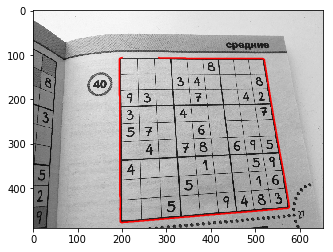

In [10]:
fig, ax = plt.subplots()
ax.imshow(image_scaled, cmap=plt.cm.gray)
ax.plot(contour[:, 0], contour[:,  1], 'r')

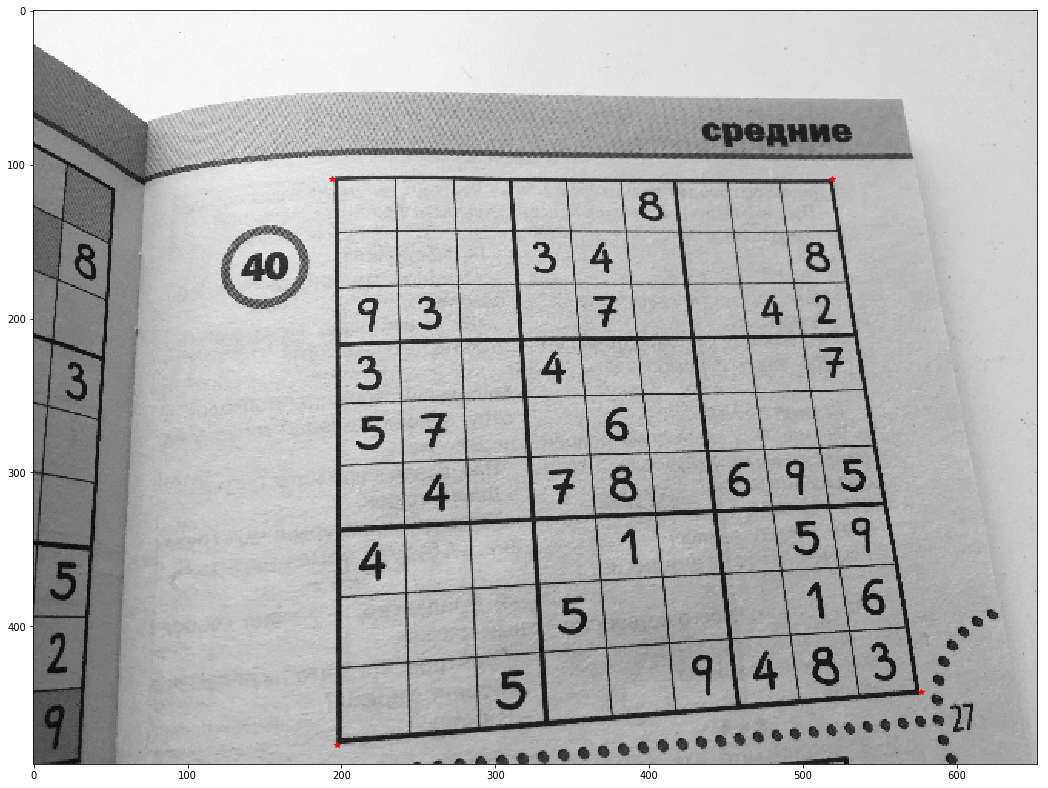

In [11]:
# epsilon allow us to control the max deviation from the original curve 
# here we use 5% of the total curve lenth 
epsilon = 0.05 * cv2.arcLength(contour, True)
corners = cv2.approxPolyDP(contour, epsilon, True).squeeze()
fig, ax = plt.subplots(figsize=(18, 18))
ax.imshow(image_scaled, cmap=plt.cm.gray)
ax.plot(corners[:, 0], corners[:, 1], '*r')

In [12]:
corners

array([[194, 109],
       [197, 477],
       [577, 443],
       [519, 109]], dtype=int32)

In [13]:
from skimage.transform import ProjectiveTransform, warp

In [14]:
points_current = sorted(corners, key=lambda x: x[0])
points_current = np.array(points_current)

points_current[:2] = np.array(sorted(points_current[:2], key=lambda x: x[1]))
points_current[2:] = np.array(sorted(points_current[2:], key=lambda x: x[1]))

a = points_current[:2][:, 0].min()
c = points_current[2:][:, 0].max()
b = points_current[::2][:, 1].min()
d = points_current[1::2][:, 1].max()

points_desired = [[a, b], [a, d], [c, b], [c, d]]
points_desired = np.array(points_desired)
print(points_current, '\n', points_desired)

[[194 109]
 [197 477]
 [519 109]
 [577 443]] 
 [[194 109]
 [194 477]
 [577 109]
 [577 477]]


In [15]:
tform = ProjectiveTransform()
tform.estimate(points_desired, points_current)
image_warped = warp(image_scaled, tform)
# plt.imshow(image_warped, cmap=cm.gray)

(490, 0)

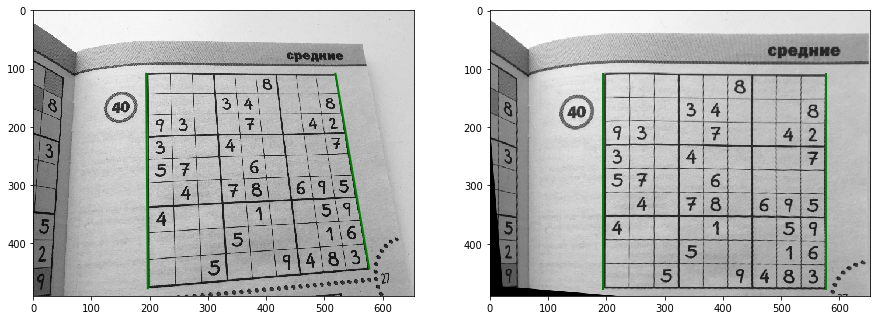

In [16]:
y_max, x_max = image_scaled.shape

fig, ax = plt.subplots(1, 2, figsize=(15, 9))
ax[0].imshow(image_scaled, cmap=cm.gray)
ax[1].imshow(image_warped, cmap=cm.gray)

for i in range(len(points_current)//2):
    ax[0].plot(*points_current[i*2:i*2+2].T, 'g', lw=2)
    ax[1].plot(*points_desired[i*2:i*2+2].T, 'g', lw=2)

ax[0].set_xlim([0, x_max])
ax[0].set_ylim([y_max, 0])

In [17]:
# print(points_current, ' ', points_desired)

In [18]:
image_crop = image_warped[min(points_desired[:, 1])+2:max(points_desired[:,1]-2), min(points_desired[:, 0])+4:max(points_desired[:,0])-5]

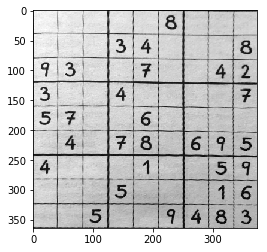

In [19]:
plt.imshow(image_crop, cmap=cm.gray)

In [20]:
image_crop.shape

(364, 374)

In [21]:
image_crop = resize(image=image_crop, output_shape=[min(image_crop.shape[0:1]),min(image_crop.shape[0:1])])

C:\Program Files\Python\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


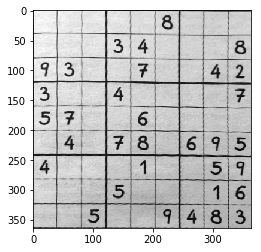

In [22]:
plt.imshow(image_crop, cmap=cm.gray)

In [23]:
from skimage.measure import LineModelND, ransac

In [24]:
sh, dl = image_crop.shape[0]//9, image_crop.shape[1]//9
print(sh, dl)

40 40


In [25]:
# fig, axs = plt.subplots(9, 9, figsize=(18, 18))

# for i in range (0,image_crop.shape[0]):
#     for j in range (0,(image_crop.shape[1])):
#         i0 = i
#         i = i + 41
#         j0 = j
#         j = j + 43
#         plt.imshow(image_crop[i0:i,j0:j], cmap=cm.gray)
        

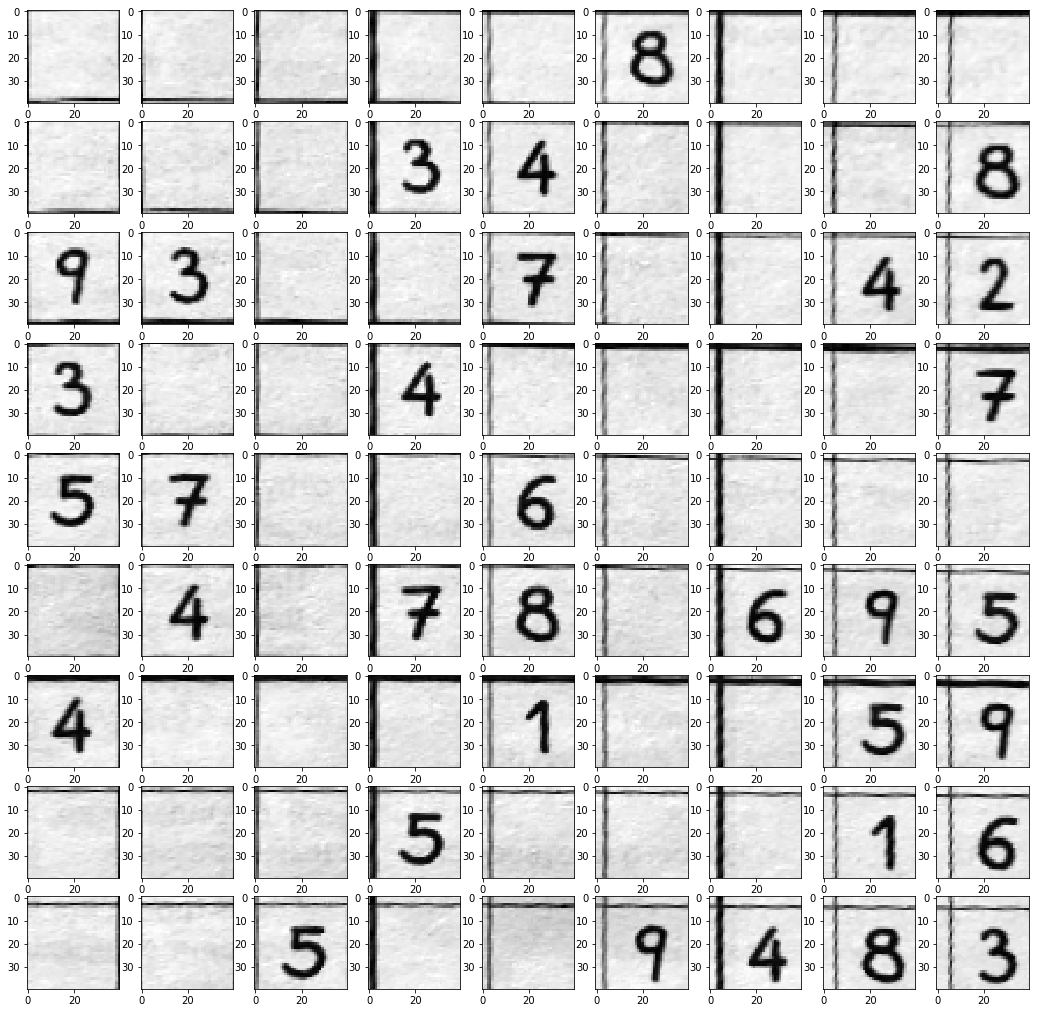

In [26]:
fig, axs = plt.subplots(9, 9, figsize=(18, 18))

for i in range(9):
    for j in range(9):
        axs[i, j].imshow(image_crop[i*sh:(i+1)*sh, j*dl:(j+1)*dl], cmap=cm.gray)
        

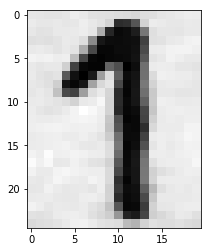

In [27]:
if k==0:
    # 1:
    i1 = image_crop[250:275,175:195]
    plt.imshow(i1, cmap=cm.gray)
if k==2:
    j1 = image_crop[5:35,10:40]
    plt.imshow(j1, cmap=cm.gray)


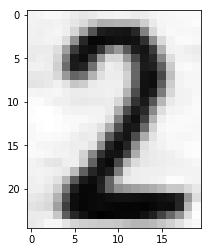

In [28]:
if k==0:
    # 2:
    i2 = image_crop[90:115,335:355]
    plt.imshow(i2, cmap=cm.gray)
if k==2:
    j2 = image_crop[105:140,210:235]
    plt.imshow(j2, cmap=cm.gray)

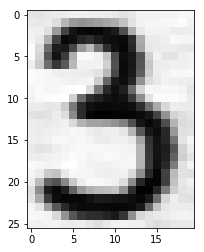

In [29]:
if k==0:
    # 3:
    i3 = image_crop[127:153,10:30]
    plt.imshow(i3, cmap=cm.gray)
if k==2:
    j3 = image_crop[12:42,160:190]
    plt.imshow(j3, cmap=cm.gray)

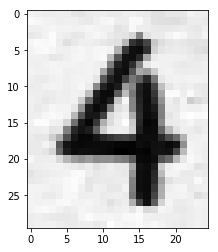

In [30]:
if k==0:
    # 4:
    i4 = image_crop[125:155,130:155]
    plt.imshow(i4, cmap=cm.gray)
if k==2:
    j4 = image_crop[105:135,60:90]
    plt.imshow(j4, cmap=cm.gray)

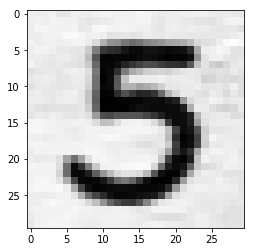

In [31]:
if k==0:
    # 5:
    i5 = image_crop[165:195,5:35]
    plt.imshow(i5, cmap=cm.gray)
if k==2:
    j5 = image_crop[105:135,355:380]
    plt.imshow(j5, cmap=cm.gray)

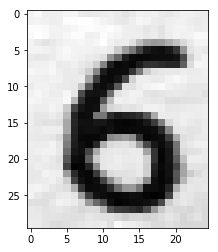

In [32]:
if k==0:
    # 6:
    i6 = image_crop[165:195,170:195]
    plt.imshow(i6, cmap=cm.gray)
if k==2:
    j6 = image_crop[10:45,260:285]
    plt.imshow(j6, cmap=cm.gray)

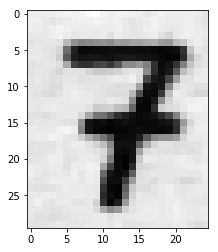

In [33]:
if k==0:
    # 7:
    i7 = image_crop[85:115,170:195]
    plt.imshow(i7, cmap=cm.gray)
if k==2:
    j7 = image_crop[55:90,115:135]
    plt.imshow(j7, cmap=cm.gray)

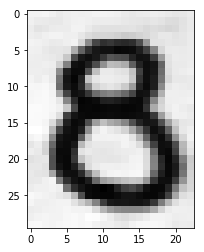

In [34]:
if k==0:
    # 8:
    i8 = image_crop[5:35,212:235]
    plt.imshow(i8, cmap=cm.gray)
if k==2:
    j8 = image_crop[60:90,210:235]
    plt.imshow(j8, cmap=cm.gray)

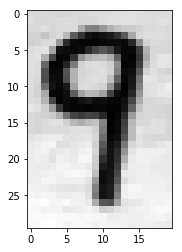

In [35]:
if k==0:
    # 9:
    i9 = image_crop[330:360,215:235]
    plt.imshow(i9, cmap=cm.gray)
if k==2:
    j9 = image_crop[105:135,300:340]
    plt.imshow(j9, cmap=cm.gray)

In [36]:
from skimage.io import imsave

In [37]:
if k==0:
    imsave('i1.jpg', i1)
    imsave('i2.jpg', i2)
    imsave('i3.jpg', i3)
    imsave('i4.jpg', i4)
    imsave('i5.jpg', i5)
    imsave('i6.jpg', i6)
    imsave('i7.jpg', i7)
    imsave('i8.jpg', i8)
    imsave('i9.jpg', i9)
elif k==2:
    imsave('j1.jpg', j1)
    imsave('j2.jpg', j2)
    imsave('j3.jpg', j3)
    imsave('j4.jpg', j4)
    imsave('j5.jpg', j5)
    imsave('j6.jpg', j6)
    imsave('j7.jpg', j7)
    imsave('j8.jpg', j8)
    imsave('j9.jpg', j9)
else:
    i1 = io.imread('./i1.jpg', plugin='matplotlib', as_grey=True)
    i2 = io.imread('./i2.jpg', plugin='matplotlib', as_grey=True)
    i3 = io.imread('./i3.jpg', plugin='matplotlib', as_grey=True)
    i4 = io.imread('./i4.jpg', plugin='matplotlib', as_grey=True)
    i5 = io.imread('./i5.jpg', plugin='matplotlib', as_grey=True)
    i6 = io.imread('./i6.jpg', plugin='matplotlib', as_grey=True)
    i7 = io.imread('./i7.jpg', plugin='matplotlib', as_grey=True)
    i8 = io.imread('./i8.jpg', plugin='matplotlib', as_grey=True)
    i9 = io.imread('./i9.jpg', plugin='matplotlib', as_grey=True)
    
    j1 = io.imread('./j1.jpg', plugin='matplotlib', as_grey=True)
    j2 = io.imread('./j2.jpg', plugin='matplotlib', as_grey=True)
    j3 = io.imread('./j3.jpg', plugin='matplotlib', as_grey=True)
    j4 = io.imread('./j4.jpg', plugin='matplotlib', as_grey=True)
    j5 = io.imread('./j5.jpg', plugin='matplotlib', as_grey=True)
    j6 = io.imread('./j6.jpg', plugin='matplotlib', as_grey=True)
    j7 = io.imread('./j7.jpg', plugin='matplotlib', as_grey=True)
    j8 = io.imread('./j8.jpg', plugin='matplotlib', as_grey=True)
    j9 = io.imread('./j9.jpg', plugin='matplotlib', as_grey=True)

C:\Program Files\Python\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [38]:
from skimage.feature import match_template
from skimage.feature import peak_local_max 

In [39]:
if k==0:
    templates = [i1, i2, i3, i4, i5, i6, i7, i8, i9]
elif k==2:
    templates = [j1, j2, j3, j4, j5, j6, j7, j8, j9]
else:
    templates = [i1, i2, i3, i4, i5, i6, i7, i8, i9, j1, j2, j3, j4, j5, j6, j7, j8, j9]

In [40]:
null = 0
results = np.zeros((9, 9), dtype=np.uint8)
for i in range(9):
    for j in range(9):
        max_correlations = [match_template(image_crop[i*sh:(i+1)*sh, j*dl:(j+1)*dl], t).max() for t in templates]
#         print(max_correlations)
        results[i, j] = np.argmax(max_correlations)%9+1 if np.max(max_correlations) > 0.7 else 0
        if results[i,j] == 0:
            null +=1


if null > 58:
    image_crop = np.rot90(image_crop, -1)
#     plt.imshow(image_crop, cmap=cm.gray)
    sh, dl = image_crop.shape[0]//9, image_crop.shape[1]//9
#     fig, axs = plt.subplots(9, 9, figsize=(18, 18))

    for i in range(9):
        for j in range(9):
            axs[i, j].imshow(image_crop[i*sh:(i+1)*sh, j*dl:(j+1)*dl], cmap=cm.gray)
    for i in range(9):
        for j in range(9):
            max_correlations = [match_template(image_crop[i*sh:(i+1)*sh, j*dl:(j+1)*dl], t).max() for t in templates]
#           print(max_correlations)
            results[i, j] = np.argmax(max_correlations)%9+1 if np.max(max_correlations) > 0.7 else 0
            if results[i,j] == 0:
                null +=1
results

array([[0, 0, 0, 0, 0, 8, 0, 0, 0],
       [0, 0, 0, 3, 4, 0, 0, 0, 8],
       [9, 3, 0, 0, 7, 0, 0, 4, 2],
       [3, 0, 0, 4, 0, 0, 0, 0, 7],
       [5, 7, 0, 0, 6, 0, 0, 0, 0],
       [0, 4, 0, 7, 8, 0, 6, 9, 5],
       [4, 0, 0, 0, 1, 0, 0, 5, 9],
       [0, 0, 0, 5, 0, 0, 0, 1, 6],
       [0, 0, 5, 0, 0, 9, 4, 8, 3]], dtype=uint8)

In [41]:
# null

In [42]:
from sudoku import solve_sudoku

In [43]:
results

array([[0, 0, 0, 0, 0, 8, 0, 0, 0],
       [0, 0, 0, 3, 4, 0, 0, 0, 8],
       [9, 3, 0, 0, 7, 0, 0, 4, 2],
       [3, 0, 0, 4, 0, 0, 0, 0, 7],
       [5, 7, 0, 0, 6, 0, 0, 0, 0],
       [0, 4, 0, 7, 8, 0, 6, 9, 5],
       [4, 0, 0, 0, 1, 0, 0, 5, 9],
       [0, 0, 0, 5, 0, 0, 0, 1, 6],
       [0, 0, 5, 0, 0, 9, 4, 8, 3]], dtype=uint8)

In [44]:
solution = solve_sudoku(results)
print(solution)

[[6 2 4 9 5 8 3 7 1]
 [1 5 7 3 4 2 9 6 8]
 [9 3 8 1 7 6 5 4 2]
 [3 8 6 4 9 5 1 2 7]
 [5 7 9 2 6 1 8 3 4]
 [2 4 1 7 8 3 6 9 5]
 [4 6 3 8 1 7 2 5 9]
 [8 9 2 5 3 4 7 1 6]
 [7 1 5 6 2 9 4 8 3]]


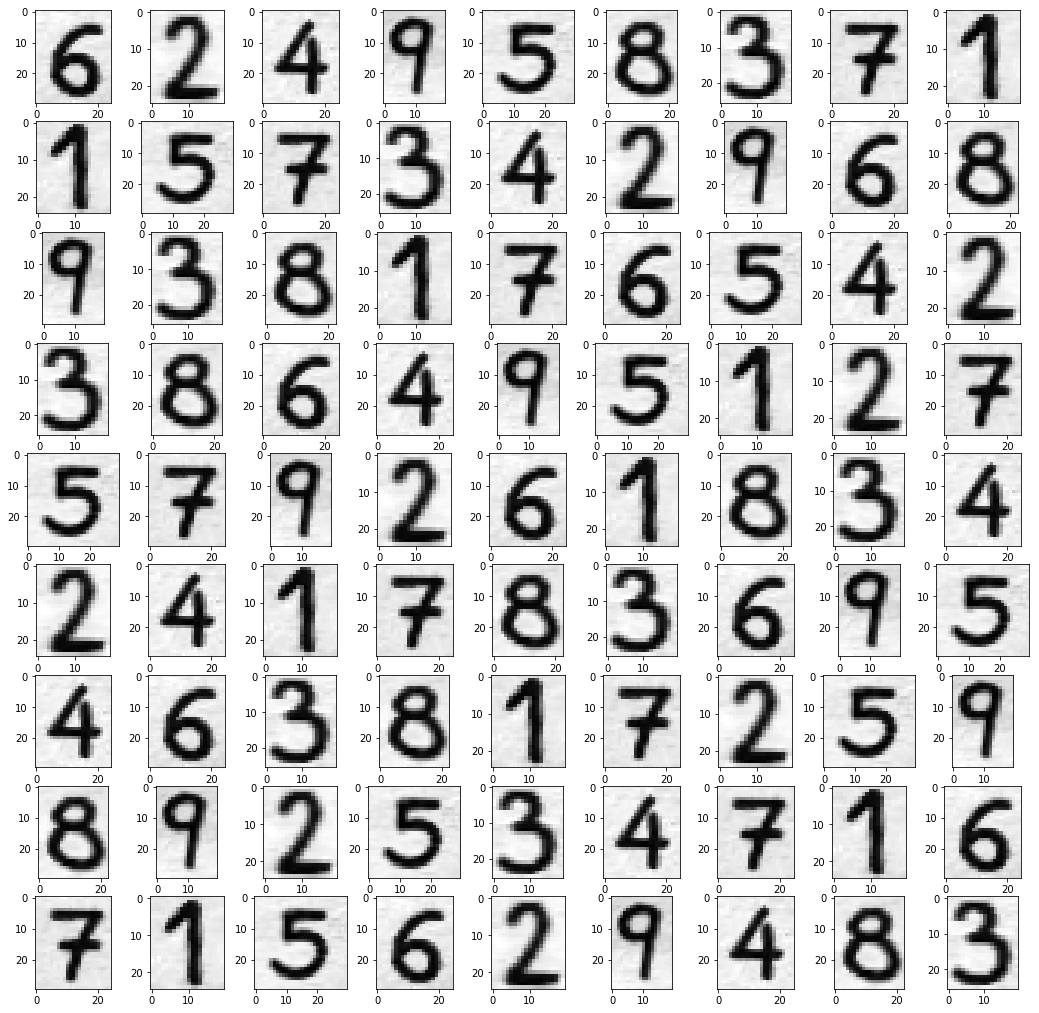

In [45]:
fig, axs = plt.subplots(9, 9, figsize=(18, 18))

for i in range(9):
    for j in range(9):
        axs[i, j].imshow(templates[solution[i,j]-1], cmap=cm.gray)
        

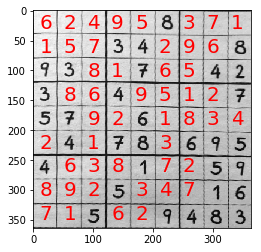

In [46]:
plt.imshow(image_crop, cmap=cm.gray)
for i in range(9):
    for j in range(9):
        if results[i,j] == 0:
            plt.text(y=i*sh+30, x=j*dl+10, s=solution[i,j], fontsize=20, color='r')